## Algorithme génétique basé sur estimation de distribution

Un algorithme génétique basé sur l'estimation de distribution (EDA) fonctionne en créant un modèle probabiliste à partir des solutions prometteuses et en utilisant ce modèle pour générer de nouvelles solutions. Voici comment un tel algorithme fonctionne.

### Étapes d'un EDA :
1. Générer une population initiale.
2. Sélectionner les meilleures solutions.
3. Construire un modèle probabiliste.
4. Générer de nouvelles solutions à partir du modèle.
5. Répéter jusqu'à convergence.

In [1]:
# importation des bibliothèques
# Import des librairies/modules
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Définition des paramètres
ONE_MAX_LENGTH = 1000

# Paramètres AG
POPULATION_SIZE = 100
MAX_GENERATIONS = 3000
WITH_TRAP = False
N_RUNS = 10

In [3]:
toolbox = base.Toolbox()
toolbox.register("zero", random.randint, 0, 0)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zero, ONE_MAX_LENGTH)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [4]:
def oneMaxFitness(individual):
    if WITH_TRAP:
        return oneMaxFitnessWithTrap(individual)
    else:
        return (sum(individual),)

# trap(u) =
# 5 if u = ONE_MAX_LENGTH,
# ONE_MAX_LENGTH − u otherwise
def oneMaxFitnessWithTrap(individual):
    u = sum(individual)
    if u == ONE_MAX_LENGTH:
        return (u,)  # Récompense maximale lorsque toutes les valeurs sont égales à 1
    else:
        return ((ONE_MAX_LENGTH - 1) - u,)  # Pénalisation proportionnelle


# Enregistrement des fonctions de fitness
toolbox.register("evaluate", oneMaxFitness)
    

In [5]:
# fonction principale de l'EAD
def EAD():
    prob_vector = [0.5] * ONE_MAX_LENGTH
    # stockage de l'historique
    logbook = []
    nb_evals = 0
    for generation in range(MAX_GENERATIONS):
        population = []
        for i in range(POPULATION_SIZE):
            individual = creator.Individual([random.random() < prob for prob in prob_vector])
            population.append(individual)
        # Evaluation de la population
        fitnesses = list(map(toolbox.evaluate, population))
        for individual, fitness in zip(population, fitnesses):
            individual.fitness.values = fitness
            nb_evals += 1
        # selections des 10 meilleurs individus
        best_individuals = tools.selBest(population, 10)
        # Mise à jour du vecteur de probabilité
        for i in range(ONE_MAX_LENGTH):
            prob_vector[i] = sum([ind[i] for ind in best_individuals]) / 10
        # Collecte des statistiques
        max_fitness = max(fitnesses)[0]
        avg_fitness = np.mean([fit[0] for fit in fitnesses])
        logbook.append({"max": max_fitness, "avg": avg_fitness, "nb_evals": nb_evals})

        # Affichage des statistiques pour chaque génération
        if generation % 1000 == 0:
            print(f"Generation {generation}: Max Fitness = {max_fitness}, Avg Fitness = {avg_fitness}")

        # Condition d'arrêt si la solution optimale est trouvée
        if max_fitness == ONE_MAX_LENGTH:
            print(f"Solution optimale trouvée à la génération {generation} !")
            break       
    return logbook

Generation 0: Max Fitness = 558, Avg Fitness = 499.76
Generation 1000: Max Fitness = 857, Avg Fitness = 857.0
Generation 2000: Max Fitness = 857, Avg Fitness = 857.0


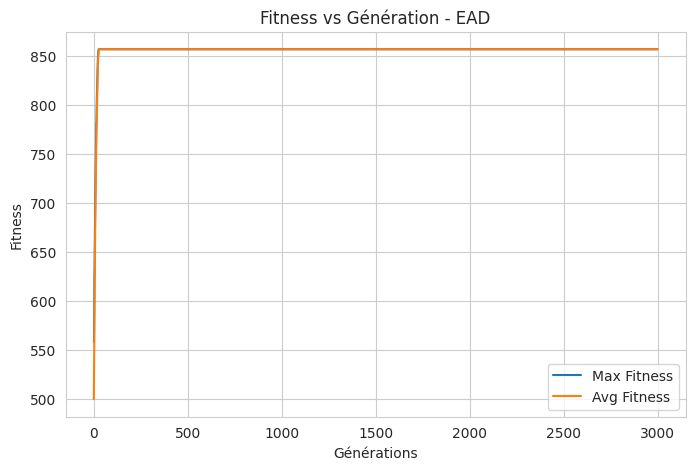

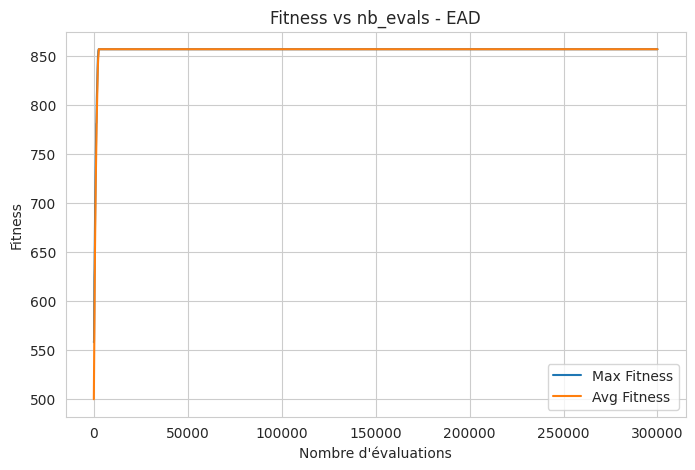

In [10]:
logbook = EAD()
def printEAD(logbook, title="EAD"):
    import matplotlib.pyplot as plt
    # Extract the data
    gens = range(len(logbook))
    max_vals = [entry["max"] for entry in logbook]
    avg_vals = [entry["avg"] for entry in logbook]
    nb_evals = [entry["nb_evals"] for entry in logbook]
    
    #
    # 1) Plot Fitness vs Generation
    #
    plt.figure(figsize=(8, 5))
    plt.plot(gens, max_vals, label="Max Fitness")
    plt.plot(gens, avg_vals, label="Avg Fitness")
    plt.xlabel("Générations")
    plt.ylabel("Fitness")
    plt.title(f"Fitness vs Génération - {title}")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    #
    # 2) Plot Fitness vs nb_evals
    #
    plt.figure(figsize=(8, 5))
    plt.plot(nb_evals, max_vals, label="Max Fitness")
    plt.plot(nb_evals, avg_vals, label="Avg Fitness")
    plt.xlabel("Nombre d'évaluations")
    plt.ylabel("Fitness")
    plt.title(f"Fitness vs nb_evals - {title}")
    plt.grid(True)
    plt.legend()
    plt.show()

printEAD(logbook, "EAD")

#### Observation : certain bit reste bloqués a 0 du a un manque de diversification
On va donc créer le même algo en incluant un range entre 0.1 et 0.9 comme probailité pour les xi de prob_vector

In [7]:
def EAD_diversification():
    # Initialisation du vecteur de probabilité à 0.5 (chaque bit a une probabilité de 0.5 d'être 1)
    prob_vector = [0.5] * ONE_MAX_LENGTH

    # Liste pour stocker l'historique des statistiques
    logbook = []

    # Paramètre pour mutation du vecteur de probabilité
    mutation_rate = 0.1
    nb_evals = 0

    # Boucle des générations
    for generation in range(MAX_GENERATIONS):
        # Génération de la population à partir du vecteur de probabilité
        population = []
        for _ in range(POPULATION_SIZE):
            individual = creator.Individual([1 if random.random() < prob else 0 for prob in prob_vector])
            population.append(individual)

        # Évaluation de la fitness
        fitnesses = list(map(toolbox.evaluate, population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit
            nb_evals += 1

        # Sélection des meilleurs individus (33% les plus performants)
        sorted_population = tools.selBest(population, len(population) // 3)

        # Mise à jour du vecteur de probabilité basé sur les meilleurs individus
        for i in range(ONE_MAX_LENGTH):
            count_one = sum(ind[i] for ind in sorted_population)
            prob_vector[i] = count_one / len(sorted_population)

            # Ajouter une légère mutation au vecteur de probabilité pour éviter la stagnation
            if random.random() < mutation_rate:
                prob_vector[i] += random.uniform(-0.05, 0.05)

            # Limiter la valeur du vecteur de probabilité entre 0 et 1
            prob_vector[i] = min(1, max(0, prob_vector[i]))

        # Collecte des statistiques
        max_fitness = max(fitnesses)[0]
        avg_fitness = np.mean([fit[0] for fit in fitnesses])
        logbook.append({"max": max_fitness, "avg": avg_fitness, "nb_evals": nb_evals})

        # Affichage des statistiques pour chaque génération
        if generation % 1000 == 0:
            print(f"Generation {generation}: Max Fitness = {max_fitness}, Avg Fitness = {avg_fitness}")

        # Condition d'arrêt si la solution optimale est trouvée
        if max_fitness == ONE_MAX_LENGTH:
            print(f"Solution optimale trouvée à la génération {generation} !")
            break
    return logbook


Generation 0: Max Fitness = 545, Avg Fitness = 499.13
Solution optimale trouvée à la génération 190 !


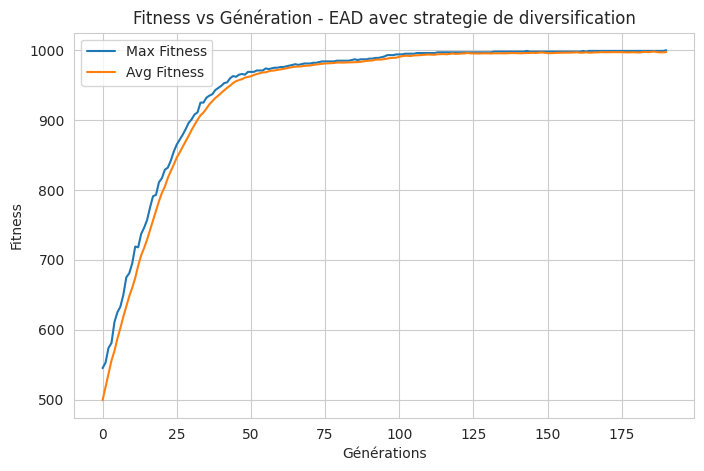

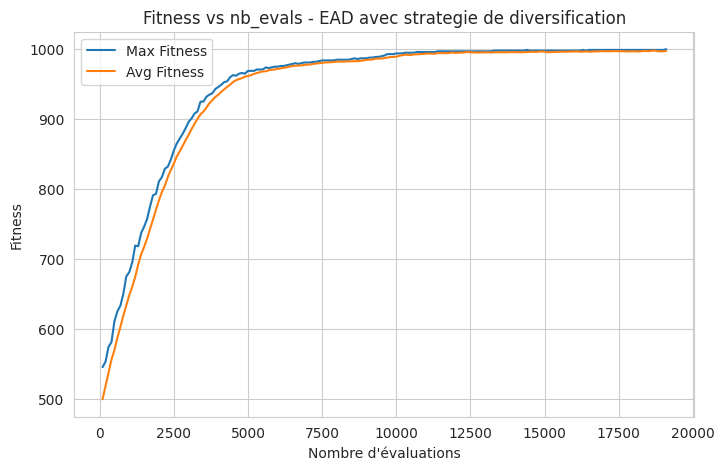

In [8]:
logbook = EAD_diversification()
printEAD(logbook, "EAD avec strategie de diversification")


=== Run 1/10 ===
Generation 0: Max Fitness = 535, Avg Fitness = 501.6
Solution optimale trouvée à la génération 150 !

=== Run 2/10 ===
Generation 0: Max Fitness = 546, Avg Fitness = 501.89
Solution optimale trouvée à la génération 198 !

=== Run 3/10 ===
Generation 0: Max Fitness = 533, Avg Fitness = 500.03
Solution optimale trouvée à la génération 122 !

=== Run 4/10 ===
Generation 0: Max Fitness = 535, Avg Fitness = 498.09
Solution optimale trouvée à la génération 131 !

=== Run 5/10 ===
Generation 0: Max Fitness = 531, Avg Fitness = 499.08
Solution optimale trouvée à la génération 183 !

=== Run 6/10 ===
Generation 0: Max Fitness = 535, Avg Fitness = 501.74
Solution optimale trouvée à la génération 185 !

=== Run 7/10 ===
Generation 0: Max Fitness = 528, Avg Fitness = 498.76
Solution optimale trouvée à la génération 139 !

=== Run 8/10 ===
Generation 0: Max Fitness = 539, Avg Fitness = 497.15
Solution optimale trouvée à la génération 196 !

=== Run 9/10 ===
Generation 0: Max Fitne

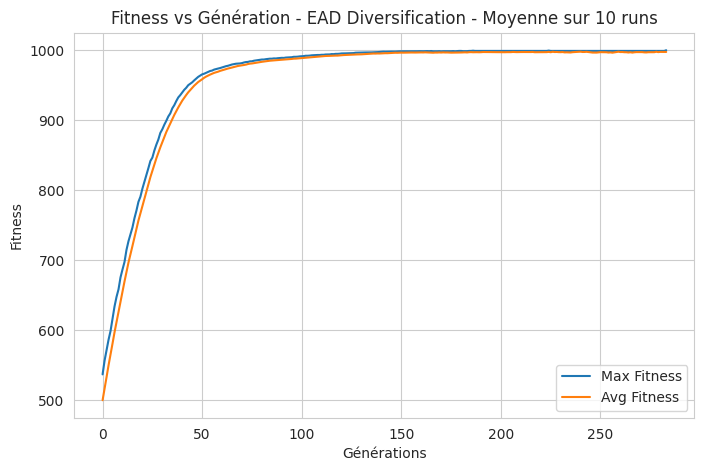

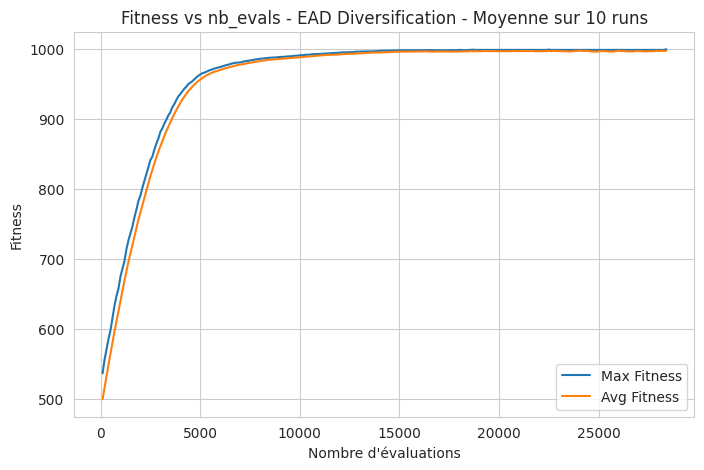

In [9]:
def run_multiple_ead():
    """
    Lance EAD_diversification() n_runs fois et renvoie
    une liste de logbooks (un logbook par run).
    """
    all_logbooks = []
    for i in range(N_RUNS):
        print(f"\n=== Run {i+1}/{N_RUNS} ===")
        logbook = EAD_diversification()
        all_logbooks.append(logbook)
    return all_logbooks

def average_logbooks(all_logbooks):
    """
    all_logbooks est une liste de logbooks (un par run).
    Chaque logbook est une liste de dictionnaires:
       [{"max": val1, "avg": val2}, {"max": val1', "avg": val2'}, ... ]
    
    Retourne un logbook moyen (même format).
    """
    import numpy as np
    
    # Longueur maximale atteinte par un logbook
    max_len = max(len(lb) for lb in all_logbooks)
    
    avg_log = []
    for g in range(max_len):
        max_values = []
        avg_values = []
        nb_evals = []
        
        # Récupère la fitness sur chaque run s'il existe la génération g
        for lb in all_logbooks:
            if g < len(lb):  # le run lb a bien une génération g
                max_values.append(lb[g]["max"])
                avg_values.append(lb[g]["avg"])
                nb_evals.append(lb[g]["nb_evals"])
        
        # Si aucun logbook ne dispose de la génération g, on arrête
        if len(max_values) == 0:
            break
        
        mean_max = np.mean(max_values)
        mean_avg = np.mean(avg_values)
        mean_evals = np.mean(nb_evals)
        
        avg_log.append({"max": mean_max, "avg": mean_avg, "nb_evals": mean_evals})
    
    return avg_log

all_logbooks = run_multiple_ead()
# Calcul de la courbe moyenne
avg_log = average_logbooks(all_logbooks)

# Visualisation
def printEAD(logbook, title="EAD"):
    # Extract the data
    gens = range(len(logbook))
    max_vals = [entry["max"] for entry in logbook]
    avg_vals = [entry["avg"] for entry in logbook]
    nb_evals = [entry["nb_evals"] for entry in logbook]
    
    #
    # 1) Plot Fitness vs Generation
    #
    plt.figure(figsize=(8, 5))
    plt.plot(gens, max_vals, label="Max Fitness")
    plt.plot(gens, avg_vals, label="Avg Fitness")
    plt.xlabel("Générations")
    plt.ylabel("Fitness")
    plt.title(f"Fitness vs Génération - {title}")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    #
    # 2) Plot Fitness vs nb_evals
    #
    plt.figure(figsize=(8, 5))
    plt.plot(nb_evals, max_vals, label="Max Fitness")
    plt.plot(nb_evals, avg_vals, label="Avg Fitness")
    plt.xlabel("Nombre d'évaluations")
    plt.ylabel("Fitness")
    plt.title(f"Fitness vs nb_evals - {title}")
    plt.grid(True)
    plt.legend()
    plt.show()

import pandas as pd
import os

def save_avg_log_to_csv(avg_log, filename="ead.csv", folder="csv"):
    """
    Sauvegarde le log moyen dans un fichier CSV à l'intérieur du dossier spécifié.
    
    avg_log : liste de dictionnaires [{"max": ..., "avg": ...}, ...]
    filename : nom du fichier CSV de sortie (par défaut 'ead.csv')
    folder   : nom du dossier dans lequel sauvegarder le CSV (par défaut 'csv')
    """
    # Créer le chemin complet : <folder>/<filename>
    if not os.path.exists(folder):
        os.makedirs(folder)  # Crée le dossier 'csv' s'il n'existe pas déjà

    filepath = os.path.join(folder, filename)
    
    # Construire un DataFrame avec 3 colonnes : generation, max, avg
    data = {
        "generation": list(range(len(avg_log))),
        "fitness": [entry["max"] for entry in avg_log],
        "nb_evals": [entry["nb_evals"] for entry in avg_log]
    }
    df = pd.DataFrame(data)
    
    # Sauvegarder dans un CSV
    df.to_csv(filepath, index=False)
    print(f"Fichier sauvegardé avec succès dans : {filepath}")

# Exemple d'utilisation
all_logbooks = run_multiple_ead()
avg_log = average_logbooks(all_logbooks)

# Sauvegarder dans le sous-dossier csv avec le nom ead.csv
save_avg_log_to_csv(avg_log, filename="ead.csv", folder="csv")

# Afficher la courbe moyenne
printEAD(avg_log, "EAD Diversification - Moyenne sur " + str(N_RUNS) + " runs")


